Load Python Libraries

In [2]:
Version: 3

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
SolarFarmSize = 150
ElectrolyserPower = 42
BatteryCapacity = 13

Input Solar Farm Size in MW and output Solar Farm hourly power in a year

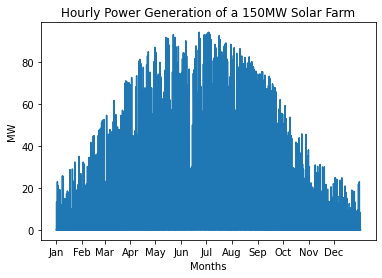

In [87]:
#set up data with relevant columns for irradiance
df = pd.read_csv("C:/Users/tangl/OneDrive/Engineering Course/Year 3/3YP/Data/ninja_weather_51.7508_-1.2538_uncorrected.csv")

totalIrr = 0.001*df["radiation_surface"] #gives radiation in kW/m^2

#gotta be careful here - irradiance needs to account for time methinkst
#to get kWh/m2 we need to multiply each half hour figure by 0.5
#i take that back, the reason i originally didn't change it is because it is for one hour each, so kWh is just kW * 1 so no change needed
    
class solar_model:
    """Non-dispatchable asset base class"""
    def __init__(self):
        self.capacity = 144 #kW
        self.efficiency = 0.17 #taken from average, will be specified
        self.area = 1.9404 #m^2, taken from 72 cell 99*196cm panel
#class for pvAsset
class pvAsset(solar_model):
    """PV Asset Class"""
    def __init__(self, Power):                              #Power is in MW
        self.capacity = 300
        self.efficiency = 0.183
        self.area = 1.6368
        self.nPanels = round((Power*1000000)/300)
        self.Power = Power
        
pvChosen = pvAsset(SolarFarmSize)                                      # CHOOSE SOLAR FARM CAPACITY HERE!!!!!!@@@@@@

percAreaEff = 0.7 #due to angles of tilt vs sunlight etc
total_capacity = pvChosen.nPanels*pvChosen.capacity
total_Area = pvChosen.nPanels*pvChosen.area*percAreaEff
areaEff = total_Area*pvChosen.efficiency
hourlyGen1 = areaEff*totalIrr

Power = hourlyGen1*0.001
ax = plt.subplot(1,1,1)

plt.plot(Power)
plt.ylabel("MW")
plt.xticks([0,744,1392,2136,2856,3600,4320,5064,5808,6528,7272,7992])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Months')
plt.title("Hourly Power Generation of a 150MW Solar Farm")
plt.show()


Load object classes for subsequent analysis

In [88]:
class electrolyzer:
    def __init__(self,production_rate,max_power):
        self.production_rate = production_rate     #kg of hydrogen produced per second per MW of electricity
        self.max_power = max_power                 #in MW
        
class alkaline(electrolyzer):
    def __init__(self,production_rate, max_power):
        super().__init__(production_rate, max_power)
        self.min_power = max_power*15/100  # in MW, minimum power to retain its ability to ramp up and down quickly  
        self.lifetime = 65000
        self.install_cost = max_power * 908 *1000
        
class ITM_PEM(electrolyzer):
    def __init__(self,production_rate, max_power):
        super().__init__(production_rate, max_power)
        self.min_power = max_power*10/100  # in MW, minimum power to retain its ability to ramp up and down quickly  
        self.lifetime = 50000
        self.install_cost = max_power * 432 *1000
    
class location:
    def __init__(self, var_waterprice, fixed_waterprice,var_elec_price,fixed_elec_price):
        self.var_waterprice = var_waterprice               # price per m3
        self.fixed_waterprice = fixed_waterprice           # price per day 
        self.var_elec_price = var_elec_price                       #GBP Per MWh
        self.fixed_elec_price = fixed_elec_price                  #GBP Per day
        
class battery:
    def __init__(self, capacity):                           # input capacity is in MWh
        self.power_rating = 0.25 * capacity           # power rating (in MW) of battery is pegged to capacity (in MWh)
        self.capacity = capacity *3600                    # energy capacity of battery in MJ

Input: water and electricity costs, electrolyser power, battery capacity

In [89]:
Oxford = location(1.4570,(17.84/365),136.4, 0.2740)
electrolyser = ITM_PEM(0.00486, ElectrolyserPower)
batt = battery(BatteryCapacity)

Operating Hours

In [90]:
T = len(Power)                           # no. of hourly periods

state = np.ones((T,1)) 
for i in range(0,105):
    state[0+i*24:7+i*24] =0
    state[17+i*24:25+i*24] =0

for i in range(105,245):
    state[0+i*24:5+i*24] =0
    state[19+i*24:25+i*24] =0

for i in range(245,365):
    state[0+i*24:7+i*24] =0
    state[17+i*24:25+i*24] =0
    


Electrolyser operation

[9340.82846496]


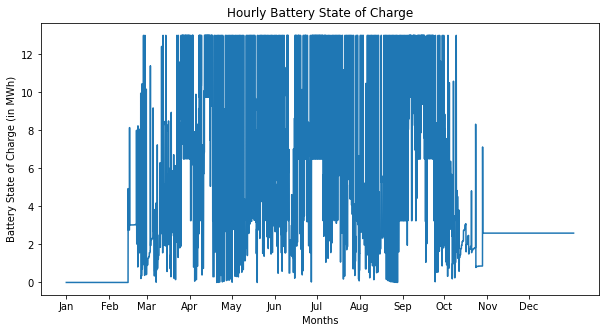

In [91]:
grid_demand = np.zeros((T,1))            # power required from grid 
H_produced = np.zeros((T,1))             # kg of hydrogen produced in the hour period
batt_power = np.zeros((T,1))             #Amt of power loaded into battery in MW
batt_soc = np.zeros((T,1))               #Amt of energy stored in battery in MJ
excess_solar = np.zeros((T,1))           #MW
electrolyzer_power = Power

# Records hydrogen produced in each hour period
for j in range(T):
    #if electrolyser is on
    if state[j] == 1:
        H_produced[j] = electrolyser.max_power*electrolyser.production_rate*60*60 
        if electrolyzer_power[j] >= electrolyser.max_power:                              #if theoretical power exceeds max power
            batt_power[j] = min((electrolyzer_power[j] - electrolyser.max_power), batt.power_rating)
            if batt_power[j] == batt.power_rating:
                excess_solar[j] = electrolyzer_power[j] - batt.power_rating - electrolyser.max_power
            batt_soc[j] = min((batt_soc[j-1] + batt_power[j]*60*60), batt.capacity)
            if batt_soc[j-1] == batt.capacity:
                excess_solar[j] = electrolyzer_power[j] - electrolyser.max_power
        else:                                                                           #if theoretical power is below min power
            grid_demand[j] = electrolyser.max_power - electrolyzer_power[j] 
            
            if grid_demand[j] > batt.power_rating:                                 #if power demand exceeds battery power rating
                if batt_soc[j-1] > batt.power_rating*60*60:
                    batt_soc[j] = batt_soc[j-1] - batt.power_rating*3600
                    grid_demand[j] = grid_demand[j] - batt.power_rating
                else:
                    batt_soc[j] = batt_soc[j-1]
            elif grid_demand[j] < batt.power_rating:                               #if power demand is within battery power rating
                #if there is sufficient energy in battery storage
                if batt_soc[j-1] > grid_demand[j]*60*60:
                    batt_soc[j] = batt_soc[j-1] - grid_demand[j]*3600
                    grid_demand[j] = 0
                else:
                    batt_soc[j] = batt_soc[j-1]
                
    #if electrolyser is off
    else:
        H_produced[j] = 0
                
        if batt_soc[j-1] == batt.capacity:
            excess_solar[j] = electrolyzer_power[j]
            batt_soc[j] = batt_soc[j-1]
        else:
            if electrolyzer_power[j] > batt.power_rating:
                excess_solar[j] = electrolyzer_power[j] - batt.power_rating
                batt_soc[j] = min((batt_soc[j-1] + batt.power_rating*60*60), batt.capacity)
            else:
                batt_soc[j] = min((batt_soc[j-1] + electrolyzer_power[j]*60*60), batt.capacity)
        
plt.figure(figsize = (10,5))

ax = plt.subplot(1,1,1)
plt.plot(batt_soc/3600)
plt.title("Hourly Battery State of Charge")
plt.xticks([0,744,1392,2136,2856,3600,4320,5064,5808,6528,7272,7992])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Months')
plt.ylabel('Battery State of Charge (in MWh)')

print(batt_soc[8500])



Text(0.5, 0, 'Months')

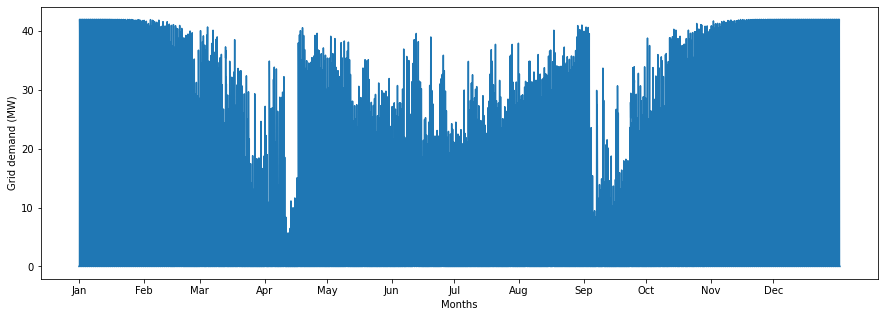

In [92]:
plt.figure(figsize = (15,5))

ax = plt.subplot(1,1,1)
plt.plot(grid_demand)
plt.ylabel('Grid demand (MW)')
plt.xticks([0,744,1392,2136,2856,3600,4320,5064,5808,6528,7272,7992])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Months')



Text(0.5, 0, 'Months')

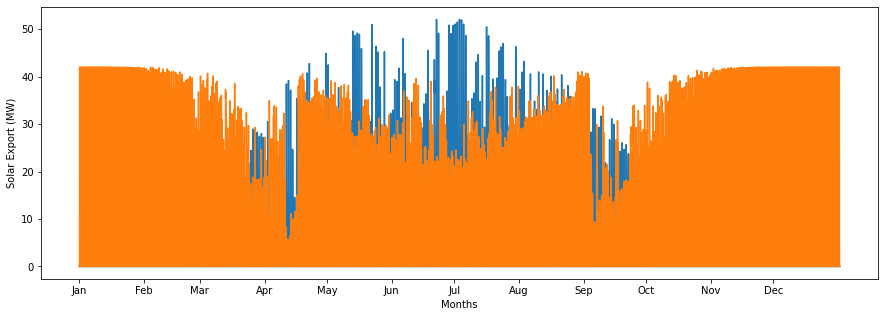

In [25]:
plt.figure(figsize = (15,5))

ax = plt.subplot(1,1,1)
plt.plot(excess_solar)
plt.plot(grid_demand)

plt.ylabel('Solar Export (MW)')
plt.xticks([0,744,1392,2136,2856,3600,4320,5064,5808,6528,7272,7992])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Months')

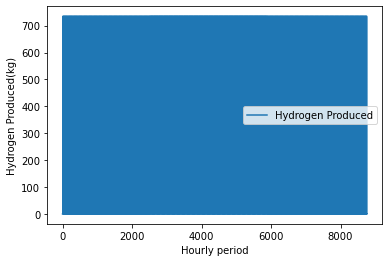

In [26]:
ax = plt.subplot(1,1,1)
plt.plot(H_produced, label = 'Hydrogen Produced')
plt.xlabel('Hourly period')
plt.ylabel('Hydrogen Produced(kg)')

ax.legend()


Total hydrogen produced (in kg) is
[3093642.71999986]


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

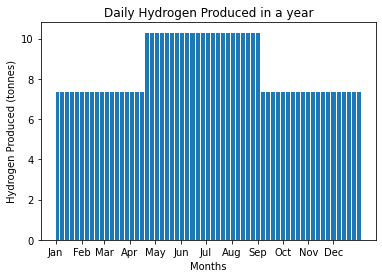

In [27]:
No_of_days = T/24
No_of_days = int(No_of_days)
daily_H2_pd = np.zeros((No_of_days))
for i in range(int(No_of_days)):
    daily_H2_pd[i] = sum(H_produced[(0 + i*24):(24 + i*24)])

ax = plt.subplot(1,1,1)

#plt.plot(daily_H2_pd, label = 'Daily Hydrogen Produced')
daysNum = len(daily_H2_pd)
daySet = np.arange(1,daysNum+1)
plt.bar(daySet,daily_H2_pd/1000)
plt.title("Daily Hydrogen Produced in a year")
plt.xticks([0,31,58,89,119,150,180,211,242,272,303,333])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Months')
plt.ylabel('Hydrogen Produced (tonnes)')

total_annual_hydrogen = sum(H_produced)
print('Total hydrogen produced (in kg) is')
print(total_annual_hydrogen)
sum(H_produced[(0 + 180*24):(24 + 180*24)])
(state[(0 + 1*24):(24 + 1*24)])

Costs

In [28]:
#Solar Power needed in each hour
co2persolar = 0    #gCO2e per kWh

solar_power = np.zeros((T,1))
for j in range(T):
    if state[j] == 1 :  
        solar_power[j] = electrolyzer_power[j]
    if state[j] == 0 :
        solar_power[j] = batt_power[j]
solar_co2_emissions = sum(solar_power*co2persolar*1000)       #in grams

co2perelec = 256                                               #gCO2e per kWh
grid_co2_emissions = sum(grid_demand*co2perelec)               #in kilograms


print('Total co2 emissions (in kg) from electricity is')
print(solar_co2_emissions+grid_co2_emissions)

# Grid Electricity Costs
Total_elec_cost =sum(grid_demand* Oxford.var_elec_price) + T/24*Oxford.fixed_elec_price
print('Total cost of grid electricity consumption is')
print(Total_elec_cost)

# Water costs
Water_consumption = 9                                         #kg of water needed for each kg of hydrogen
Total_water_price = T/24*Oxford.fixed_waterprice + sum(H_produced*Water_consumption*Oxford.var_waterprice/1000)
print('Total cost of water consumption is')
print(Total_water_price)

# Excess solar power 
print('Total solar energy sold(in MWh) is')
print(sum(excess_solar))

# Operating Lifetime
lifetime = electrolyser.lifetime
print('Total operating lifetime(in hours) is')
print(lifetime)

# Net Present Value of electrolyser
discount_rate = 0.035
operating_hours = np.count_nonzero(H_produced)                 # Number of operating hours in a year
years_lifetime = lifetime/operating_hours                      # Lifetime in number of years
years_lifetime_rounded = np.round(years_lifetime)              # round off number of years
years_lifetime_rounded = int(years_lifetime_rounded)
print('Total operating lifetime(in years) is')
print(years_lifetime_rounded)
annual_cost = electrolyser.install_cost/years_lifetime_rounded

cost = np.zeros((years_lifetime_rounded,1))   
for j in range(years_lifetime_rounded):
    cost[j] = annual_cost *((1-discount_rate)**j)
    
npv = sum(cost)
print('Electrolyser cost is ')
print(electrolyser.install_cost)
print('Net Present Value of Electrolyser Cost is ')
print(npv)

solarfarm_cost = pvChosen.Power * 450000                   # Cost of solar farm in GBP 

print('Cost of Solar Farm Installation')
print(solarfarm_cost)

solarfarm_OM = 6700*SolarFarmSize
print('Cost of Solar Farm O & M')
print(solarfarm_OM)
batt_cost = batt.capacity/3600 * 89.28                      # Cost of battery in GBP

print('Cost of Battery')
print(batt_cost)

Total co2 emissions (in kg) from electricity is
[18259412.42657927]
Total cost of grid electricity consumption is
[9728943.19353682]
Total cost of water consumption is
[40584.77698736]
Total solar energy sold(in MWh) is
[26139.11056251]
Total operating lifetime(in hours) is
50000
Total operating lifetime(in years) is
12
Electrolyser cost is 
18144000
Net Present Value of Electrolyser Cost is 
[15028400.41567628]
Cost of Solar Farm Installation
67500000
Cost of Solar Farm O & M
1005000
Cost of Battery
1160.64


In [156]:
print('Total hydrogen produced (in kg) is')
print(total_annual_hydrogen)

Total hydrogen produced (in kg) is
[3093642.71999986]


In [40]:
Total_Cost = batt_cost + solarfarm_cost + electrolyser.install_cost + Total_water_price + Total_elec_cost
print(Total_Cost)

[95414688.61052418]


In [14]:
pd.DataFrame(daily_H2_pd).to_csv(r'C:/Users/tangl/OneDrive/Engineering Course/Year 3/3YP/data.csv',index = False)

In [41]:
print(sum(grid_demand))

[71325.82979133]


In [118]:
summer_solar_power = electrolyzer_power[4103:4128]
summer_solar_power = summer_solar_power.to_numpy()
summer_battsoc = batt_soc[4103:4128]
summer_battsoc = summer_battsoc/3600
summer_export = excess_solar[4103:4128]
summer_grid = grid_demand[4103:4128]
summer_grid = summer_grid[5:20]
electrolyser_consumption = np.zeros((25,1))
electrolyser_consumption[6:20] = 42
y = np.zeros((25,1))
for i in range(len(y)):
    y[i] = i
    
grid_y = np.zeros((15,1))
for i in range(len(grid_y)):
    grid_y[i] = i+5
len(summer_grid)
print(state[4123])
print(electrolyzer_power[4123])



[0.]
5.440518190800001


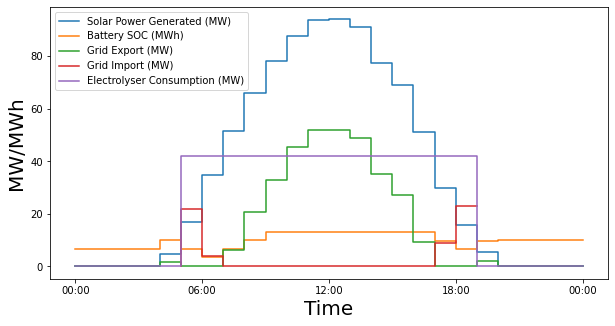

In [119]:
plt.figure(figsize = (10,5))
ax = plt.subplot(1,1,1)
plt.step(y,summer_solar_power, label='Solar Power Generated (MW)')
plt.step(y,summer_battsoc, label='Battery SOC (MWh)')
plt.step(y,summer_export, label='Grid Export (MW)')
plt.step(grid_y,summer_grid, label='Grid Import (MW)')
plt.step(y,electrolyser_consumption, label='Electrolyser Consumption (MW)')


plt.xticks([0,6,12,18,24])
ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])

plt.ylabel('MW/MWh', color='k',size=20)
plt.xlabel('Time', color='k',size=20)
ax.legend()
plt.show()

In [122]:
winter_solar_power = electrolyzer_power[8520:8545]
winter_solar_power = winter_solar_power.to_numpy()
winter_battsoc = batt_soc[8520:8545]
winter_battsoc = winter_battsoc/3600
winter_export = excess_solar[8520:8545]
winter_grid = grid_demand[8520:8545]
winter_grid = winter_grid[7:18]
electrolyser_consumption = np.zeros((25,1))
electrolyser_consumption[8:18] = 42
y = np.zeros((25,1))
for i in range(len(y)):
    y[i] = i
    
grid_y = np.zeros((11,1))
for i in range(len(grid_y)):
    grid_y[i] = i+7



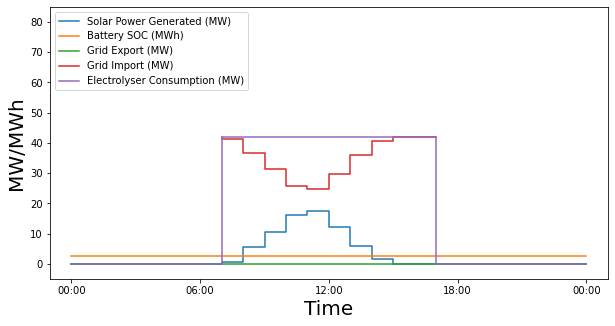

In [123]:
plt.figure(figsize = (10,5))
ax = plt.subplot(1,1,1)
plt.step(y,winter_solar_power, label='Solar Power Generated (MW)')
plt.step(y,winter_battsoc, label='Battery SOC (MWh)')
plt.step(y,winter_export, label='Grid Export (MW)')
plt.step(grid_y,winter_grid,label='Grid Import (MW)')
plt.step(y,electrolyser_consumption, label='Electrolyser Consumption (MW)')


plt.xticks([0,6,12,18,24])
ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])

plt.ylabel('MW/MWh', color='k',size=20)
plt.xlabel('Time', color='k',size=20)
ax.set(xlim=(-1,25), ylim=(-5, 85))
ax.legend(loc = 2)
plt.show()